### Analysis of Concordance betweeen VO2Max and Heart Snaphsot
The following notebook summarizes the data and generates all of the statistical analysis and figures presented in the paper:


    
This analysis is dependent on data stored in [Synapse](www.synapse.org) a collaborative data platform.  Versioned datasets are referenced by their synapseIds (e.g. 'syn22269050').  To re-execute this notebook you will have access to Synapse by registering for a free account and requested access to the data at [https://www.synapse.org/#!Synapse:syn22107959/](https://www.synapse.org/#!Synapse:syn22107959/). For information about getting started with Synapse please see: https://docs.synapse.org/articles/getting_started.html
   


In [1]:
import synapseclient
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import scipy.stats as stats
from collections import Counter as c
import sparklines

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
mpl.rcParams['figure.figsize'] = (15.0, 8.0)
mpl.rc('font', **{'family' : 'Arial','size'   : 14})


syn = synapseclient.login()

## Heart Rate Callibration study data
hr_data_entity_id = 'syn22269050'
metadata_entity_id = 'syn22268058'
skin_tone_id = 'syn22269051'
spectrocolorimetry_entity_id = 'syn22268040'

## VO2Max Validation study data
EPARC_DATA = 'syn22268523'
MERGED_HR_FILE_IDS = {'tecumseh':'syn22269494', 'stress_test':'syn22269495', '12MT':'syn22269380', }
ACTIVITY_TABLE_IDS = {'12MT':'syn22254983', 'tecumseh':'syn22254980', 'stress_test':'syn22119505'}
VO2MAX_TECUMSEH_FILE_ID = 'syn22307098'
BASELINE_CHAR_VALIDATION = 'syn22254979'
COMPUTED_DISTANCES_ID = 'syn22343241'
FITZPATRICK_FILE_ID = 'syn22268524'
STAIRSTEP_STOP_TIMES_ID = 'syn22269994'
QUERY = "SELECT * FROM %s"
phone_prices = {'Huawei Mate SE':'$230',
                'LG Stylo 4':'$249',
                'Moto G6 Play':'$149',
                'Samsung Galaxy J7':'$99',
                'Samsung Galaxy S9+':'$700',
                'iPhone8+':'$349',
                'iPhoneSE':'$149',
                'iPhoneXS':'$999'
               }
CONF_CUTOFF = 0.5 #Cuttoff in confidence scores used for heart rate estimates 

Welcome, Meghasyam Tummalacherla!




UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.2.0) is available. Your version (2.0.0) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.2.0 release notes

https://python-docs.synapse.org/build/html/news.html



## Plotting functions and helper functions

In [2]:
def plot_bland_altman(x,y, c=None, xlabel='average in values', ylabel='difference in values'):
    """given measurements for x and y plots difference vs average with standard deviation lines. """
    diff_vals = x-y
    avg_vals = (x+y)/2.
    plt.scatter(avg_vals, diff_vals, c=c)
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean(),diff_vals.mean()], 'k')
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean()+diff_vals.std(),diff_vals.mean()+diff_vals.std()], 'r')
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean()-diff_vals.std(),diff_vals.mean()-diff_vals.std()], 'r')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
def ccc(x,y):
    """Computes the correlation between  two values.
    Returns Lin's concordance coefficient"""
    if len(x)==0:
        return np.NaN
    covar = np.cov(x,y, bias=False)[0][1]*(len(x)-1)/float(len(x)) 
    xvar = np.var(x, ddof=1)*(len(x)-1)/float(len(x)) 
    yvar = np.var(y, ddof=1)*(len(y)-1)/float(len(y))
    return (2 * covar) / ((xvar+yvar) +((np.mean(x)-np.mean(y))**2))
    #corr = stats.pearsonr(x, y)
    #return corr[0]
    
def icc(groups, values):
    """Computes the  intraclass correlation (ICC) using the R package ICC"""
    from rpy2.robjects import DataFrame, FloatVector, StrVector
    from rpy2.robjects.packages import importr
    r_icc = importr("ICC", lib_loc='/Library/Frameworks/R.framework/Versions/3.6/Resources/library')
    df = DataFrame({"groups": StrVector(groups),
                "values": FloatVector(values)})
    icc_res = r_icc.ICCbare("groups", "values", data=df)
    return icc_res[0] # icc_val now holds the icc value


def milligan1(HB30to60s, age):
    """Computes an estimate of VO2Max using number of heartbeats during recovery and age"""
    return (84.687 - 0.722*HB30to60s - 0.383*age)

def milligan2(HB30to60s, age, sex):
    """Computes an estimate of VO2Max using number of heartbeats during recovery, age and  gender"""
    return  83.477 - 0.586*HB30to60s - 0.404*age - 7.030*(sex=='Female')

# Load and transform Data
## Load Heart Rate Calibration Metadata
Load data from multiple data sources and print demographics and summary plots for skin and devices

In [3]:
# Get data from Synapse
calibration_metadata_entity = syn.tableQuery('select * from %s where "Participant ID">1' % metadata_entity_id)
calibration_data_entity = syn.get(hr_data_entity_id)
calibration_skintone_entity = syn.get(skin_tone_id)

# Read into data frames
calibration_metadata = calibration_metadata_entity.asDataFrame()
calibration_metadata = calibration_metadata.rename(columns = {'Participant ID': 'participantID', 'Celeb Choice - Please select the number that best matches you based on your skin.': 'celeb skintone'})
calibration_metadata = calibration_metadata.dropna(subset=['participantID'])
calibration_metadata = calibration_metadata.loc[:, ~calibration_metadata.columns.str.contains('Nonin File')]
df = pd.read_csv(calibration_data_entity.path, sep=',', index_col=0, low_memory=False)
df['redHR'] = df.redHR.astype('float')
df['greenHR'] = df.greenHR.astype('float')
df['blueHR'] = df.blueHR.astype('float')
df['window'] = df.window.str.replace('Window', '').astype('float')
df['startTime'] = pd.to_datetime(df.startTime)
df['stopTime'] = pd.to_datetime(df.stopTime)
df['%error'] = (df['redHR'] - df['noninHR'])/df['noninHR']*100

calibration_skin = pd.read_csv(calibration_skintone_entity.path, sep=',', index_col=0)
calibration_skin = calibration_skin.rename(columns = {'Participant ID': 'participantID', 'Celeb Choice - Please select the number that best matches you based on your skin.': 'celeb skintone'})
## Drop problematic data collections by dropping duplicates
#   participant 1220 was redone and this was the first
calibration_metadata = calibration_metadata[~((calibration_metadata['participantID']==1220) & 
                                              (calibration_metadata['Face L*']==67.6) & 
                                              (calibration_metadata['Face b*']==17.2))]
calibration_skin = calibration_skin[~((calibration_skin['participantID']==1220) & 
                                      (calibration_skin['Face L*']==67.6) & 
                                      (calibration_skin['Face b*']==17.2))]
#  drop the first measurement of 5640 as it was repeated and made more complete
calibration_metadata = calibration_metadata[~((calibration_metadata['participantID']==5640) & 
                                              (calibration_metadata['Face L*']==61.2) & 
                                              (calibration_metadata['Face b*']==22.4))]
calibration_skin = calibration_skin[~((calibration_skin['participantID']==5640) & 
                                      (calibration_skin['Face L*']==61.2) & 
                                      (calibration_skin['Face b*']==22.4))]

print('Last update performed %s' %calibration_data_entity.modifiedOn)
print('%i participants in survey' %len(set(calibration_metadata['participantID'])))
print('%i particpiants with phone data' % len(set(df.participantID)))
df = calibration_metadata.merge(df, on='participantID', how='right')
calibration_df = df.merge(calibration_skin[['participantID', 'face.fitzpatrick.ita', 'finger.fitzpatrick.ita', 
                    'face.fitzpatrick', 'finger.fitzpatrick']], 
                  on='participantID', how='left')
print('%i particpiants with matched data\n' % len(set(calibration_df.loc[~df['noninHR'].isna() & (df.method=='acf'), 
                                                      'participantID'])))
calibration_df[~calibration_df['noninHR'].isna() & (calibration_df.method=='acf')].groupby(['face.fitzpatrick', 'phone'])['participantID'].nunique().astype('int16').unstack('face.fitzpatrick')


Last update performed 2020-08-18T10:50:26.447Z
124 participants in survey
124 particpiants with phone data
120 particpiants with matched data



face.fitzpatrick,1,2,3,4,5
phone,,,,,
Huawei Mate SE,3,23,45,29,16
LG Stylo 4,2,25,39,28,13
Moto G6 Play,3,19,26,18,9
Samsung Galaxy J7,1,13,24,14,7
Samsung Galaxy S9+,2,18,32,17,10
iPhone 8+,3,24,44,29,15
iPhone SE,3,24,44,30,17
iPhone XS,3,23,41,27,17


## Load Validation and VO2Max Data

In [4]:
baseline_validation_entity = syn.tableQuery('select * from %s' % BASELINE_CHAR_VALIDATION)
baseline_validation = baseline_validation_entity.asDataFrame()
baseline_validation = baseline_validation.rename(columns = {'participantId': 'externalId'})


In [5]:
metadata = syn.get(EPARC_DATA)
metadata = (pd.read_excel(metadata.path)
              .assign(BMI = lambda df: df['Lab Day Wt (kg)']/(df['Height (cm)']/100)**2)
              .rename(columns={'Measured HR Max':'Max HR',
                               'Measured VO2max (mL/kg/min)': 'VO2max (mL/kg/min)',
                               'CRF User name': 'externalId'}))

# add externalId -  healthCode map from baseline_validation 
metadata = metadata.merge(baseline_validation[['externalId', 'healthCode']], how='left', on='externalId')
metadata = metadata.drop_duplicates()


#### Load the Validation Fitzpatrick skin tone values

In [6]:
ent = syn.get(FITZPATRICK_FILE_ID)
fitzpatrick = pd.read_excel(ent.path)

#### Load all Validation HR data 
Merge HR data from different tasks into a common dataset for HR

In [7]:
numeric_cols=['samplingRate', 'redHR', 'redConf', 'greenHR', 'greenConf', 'blueHR']
dfs=[]
for name, synId in MERGED_HR_FILE_IDS.items():
    print(name, synId)
    entity  = syn.get(synId)
    df  = pd.read_csv(entity.path, index_col=0, sep=',\s+', delimiter=',', skipinitialspace=True,
                      dtype={col:  'str' for col in numeric_cols})

    for row in numeric_cols:
        df[row] = df[row].str.strip().astype(float)
    df.replace([pd.np.inf, -pd.np.inf], pd.np.nan, inplace=True)
    df['activity'] = name
    df= df[df.appVersion != 'version 1.0.2, build 1']
    # Heart rate across channels is summarized as HR of red or green choosen by highest confidence
    # Resulting HR are filtered such that only those with confidence>0.5 are kept
    redIdx = (df.redConf>df.greenConf) | (df.greenConf.isna()) #Take care of missing values with second logical statement
    df = df.assign(hr = lambda x: np.where(redIdx, x.redHR, x.greenHR),
                   conf = lambda x: np.where(redIdx, x.redConf, x.greenConf),
                   activity = name)
    # If confidence <0.5 set hr to NaN
    df.loc[df.conf<0.5,  'hr'] = np.nan
    dfs.append(df)
df = pd.concat(dfs)
df['os'] = ['iPhone' if 'iPhone' in str else 'Android' for str in df.phoneInfo]
df.loc[df['polar.hr']==0, 'polar.hr'] =np.nan #TODO verify
df_hr = df.copy()

tecumseh syn22269494


[WARNING] /Users/mtummala/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # This is added back by InteractiveShellApp.init_path()



stress_test syn22269495
12MT syn22269380


### Load Tecumseh computed VO2Max from step test HRs

In [8]:
tecumseh = syn.get(VO2MAX_TECUMSEH_FILE_ID)
tecumseh = pd.read_csv(tecumseh.path)
tecumseh = tecumseh.merge(df_hr[['recordId', 'os', 'appVersion']].drop_duplicates(), on='recordId', how='left')
#Drop measurs from earlier version of app
tecumseh= tecumseh[tecumseh.appVersion != 'version 1.0.2, build 1']

#### Load Validation Cooper test results and distance calculations

In [9]:
activityTables = {name: syn.tableQuery(QUERY  %synId).asDataFrame() for name, synId in ACTIVITY_TABLE_IDS.items()}

cooperDistances = syn.get(COMPUTED_DISTANCES_ID)
cooperDistances = pd.read_csv(cooperDistances.path, sep='\t')
cooperDistances['os'] = ['iPhone' if 'iPhone' in str else 'Android' for str in cooperDistances.phoneInfo]

df_12mt = activityTables['12MT']

df_12mt = df_12mt.merge(cooperDistances[['recordId', 'estimated_smoothed_distance', 'estimated_distance', 'actual_distance']], how='left', on='recordId', )
df_12mt['mobile Cooper'] = (df_12mt['estimated_smoothed_distance'] - 504.9)/44.73
df_12mt['inClinic'] = ~df_12mt.actual_distance.isna()

# Table 1

In [10]:
def percent_white(x):
    return sum(x=='White')/len(x)*100
percent_white.__name__ = '% White'

def sparkline_str(x):
    bins=np.histogram(x, [120,130,140,150,160,170,180,190,200,210])[0]
    avg = np.mean(x)
    sl = ''.join(sparklines.sparklines(bins))+'({0:,.0f})'.format(avg)
    return sl
sparkline_str.__name__ = ""

def sparkline_str_vo2max(x):
    bins=np.histogram(x, [15,20,25,30,35,40,45,50,55,60,65])[0]
    avg = np.mean(x)
    sl = ''.join(sparklines.sparklines(bins))+'({0:,.0f})'.format(avg)
    return sl
sparkline_str_vo2max.__name__ = ""

def mean_std(x):
    return '{0:,.1f} +/- {1:,.1f}'.format(np.mean(x), np.std(x))
mean_std.__name__ = 'mean +/- std'

def N_female(x):
    return '{}  ({}|{})'.format(len(x), sum(x=='Female'), sum(x=='Male'))
N_female.__name__ = 'N (F|M)'

format_dict = {'mean':'${0:,0.1f}'}

(metadata.groupby([pd.cut(metadata.Age, pd.np.arange(20, 81, 10))])
     .agg({'Sex': [N_female], 
           'Age':mean_std,
           'Ethnicity': percent_white,
           'BMI': mean_std,
           # 'Lab Resting HR': 'mean',
           'Max HR':sparkline_str,
           'VO2max (mL/kg/min)': sparkline_str_vo2max})
    .style.format(format_dict))

[WARNING] /Users/mtummala/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,Sex,Age,Ethnicity,BMI,Max HR,VO2max (mL/kg/min)
,N (F|M),mean +/- std,% White,mean +/- std,,
Age,,,,,,
"(20, 30]",16 (7|9),24.6 +/- 3.2,43.750000,24.0 +/- 2.9,▁▁▁▁▁▂▃█▂(193),▁▁▁▃▄▆█▆▄▃(47)
"(30, 40]",20 (14|6),35.5 +/- 3.1,65.000000,24.0 +/- 3.5,▁▁▁▁▃▃█▄▃(186),▁▂▂▁▇▅▇█▄▁(44)
"(40, 50]",20 (13|7),44.7 +/- 3.0,65.000000,26.8 +/- 5.4,▁▁▁▁▄▅█▄▁(181),▂▁▂▆▆█▃▂▂▁(39)
"(50, 60]",19 (8|11),55.3 +/- 2.9,68.421053,27.0 +/- 3.9,▁▁▂▁██▆▃▁(174),▁▁▄▆▂█▃▂▃▁(40)
"(60, 70]",14 (11|3),64.8 +/- 3.2,85.714286,28.5 +/- 4.7,▁▃▂▃█▃▂▁▁(160),▂▃▄█▂▁▂▁▁▁(31)
"(70, 80]",5 (3|2),75.0 +/- 3.4,100.000000,27.1 +/- 3.0,▄▄█▁▄▁▁▁▁(141),▁▁█▃▁▃▁▁▁▁(31)


# Figure 1

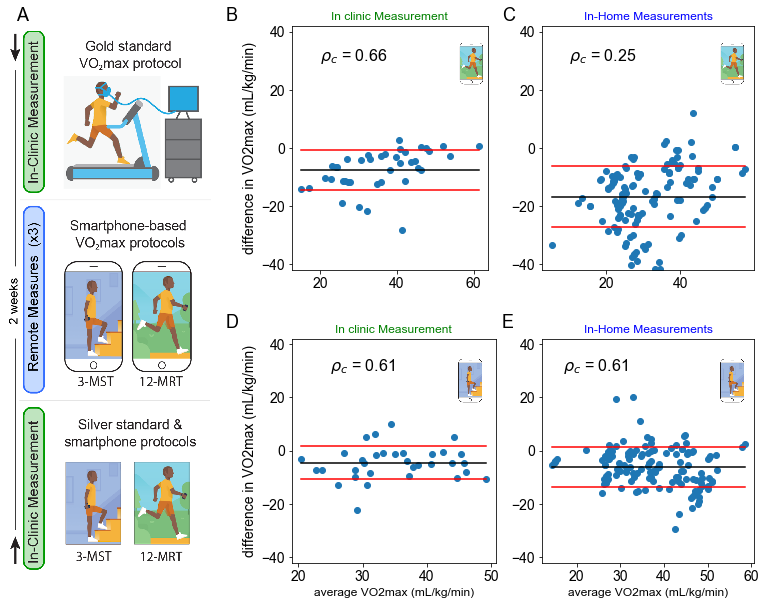

In [11]:
df = df_12mt.copy()
df = df[df['answers.surveyAfter']=='Nothing, was my best effort']
#Merge in true VO2
df = df.merge(metadata[['healthCode', 'Age', 'Sex','Cooper VO2', 'VO2max (mL/kg/min)']], how='left', on='healthCode')

plt.figure(figsize=(11,11));

#Cooper in lab from smartphone vs VO2Max
ax = plt.subplot(232)
ax.set_position([0.395419, 0.645333, 0.247004, 0.308000])
tmp = df[df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                 ylabel='difference in VO2max (mL/kg/min)', xlabel='');
plt.text(20,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
        fontsize=16,fontname='Arial');
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')
plt.ylim(-42,42);
plt.grid(False);

#Cooper at home from smartphone vs VO2Max
ax=plt.subplot(233);
ax.set_position([0.711225, 0.645333, 0.267941, 0.308000])
tmp = df[~df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='');
plt.text(10,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
        fontsize=16,  fontname='Arial');
plt.title('In-Home Measurements', fontsize=12, fontname='Arial', color= 'Blue')
plt.ylim(-42,42);
plt.grid(False);

# 3 Minute Step test data
df = tecumseh.copy()
df = df.merge(metadata[['externalId', 'Lab Day Wt (kg)', 'Age', 'Sex','Cooper VO2', 
                        'VO2max (mL/kg/min)', 
                        'Step Test HR Beats']], how='left', on='externalId')
df = df[df.metric=='camerahr']
tmp =df[['externalId', 'inClinic','vo2Max.Milligan2', 'VO2max (mL/kg/min)', 'os']].dropna().groupby(['externalId', 'inClinic']).mean()

#3MST in lab from smartphone vs VO2Max
ax = plt.subplot(235)
ax.set_position([0.395419, 0.275654, 0.257004, 0.283105])
tmp = df[df.inClinic].dropna(subset=['vo2Max.Milligan2','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['vo2Max.Milligan2'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='difference in VO2max (mL/kg/min)', xlabel='average VO2max (mL/kg/min)');
plt.text(25,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']),
        fontsize=16, fontname='Arial');
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')
plt.ylim(-42,42);
plt.grid(False);

#3MST in lab from smartphone vs VO2Max
ax = plt.subplot(236)
ax.set_position([0.711225, 0.275654, 0.267941, 0.283105])
tmp = df[~df.inClinic].dropna(subset=['vo2Max.Milligan2','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['vo2Max.Milligan2'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='', xlabel='average VO2max (mL/kg/min)');
plt.text(17,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']),
        fontsize=16, fontname='Arial');
plt.title('In-Home Measurements', fontsize=12, fontname='Arial', color= 'Blue')
plt.ylim(-42,42);
plt.grid(False);


#Plot protocol image
ax =  plt.figure(1).add_axes([0.035852, 0.255654, 0.257057, 0.701609]) 
plt.imshow(plt.imread(syn.get('syn22277074').path))
plt.axis('off');

#Set parameters on Figure and annotate
for ax in plt.figure(1).axes:
    ax.get_xaxis().get_label().set_fontname("Arial")
    ax.get_xaxis().get_label().set_fontsize(12.000000)

plt.figure(1).text(0.047358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.311535, 0.959621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.660518, 0.959621, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.311535, 0.572782, 'D', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.660518, 0.572782, 'E', transform=plt.figure(1).transFigure,fontsize=18, fontname="Arial");

#Add icons 
plt.axes([0.60540, 0.476171, 0.031425, 0.059172])
plt.imshow(plt.imread(syn.get('syn22277072').path)) #3MST icon
plt.axis('off');
plt.axes([0.93540, 0.476171, 0.031425, 0.059172])
plt.imshow(plt.imread(syn.get('syn22277072').path)) #3MST icon
plt.axis('off');
plt.axes([0.605840, 0.876851, 0.031425, 0.057068])
plt.imshow(plt.imread(syn.get('syn22277073').path)) #12MRT icon
plt.axis('off');
plt.axes([0.93540, 0.876851, 0.031425, 0.057068])
plt.imshow(plt.imread(syn.get('syn22277073').path)) #12MRT icon
plt.axis('off');

plt.savefig('../figure1.pdf');

**Figure 1** Visual abstract and primary results of validation. (A) Visual abstract, participants in the study were randomized into two groups.  The first group performed a gold standard VO2Max protocol and recieved traning on day 1 while the second group performed the two smartphone protocols on day 1, both groups then performed the two protocols at home three times during a two week period before coming back into the clinic to perform the app measures in lab (group 1) or gold standard VO2Max (group 2). B-E show Bland-Altman plots comparing the Gold standard VO2Max with smartphone measures from : B) Cooper run test performed in lab, C) Cooper test at home (up to 3 repeats per participant), D) 3MST in lab, and E) 3MST at home.  For upper limits of performance comparing non-smartphone measures to gold standard see supplemental figures xxx-yy

### Supplemental Figure 1 Ground truth vs lab based tests 
* Cooper vs V02Max from distance measured using track. 
* Tecumseh vs VO2max from heart rate count.
* Effect on Cooper based on self reported effort

Rho_c between Polar chest strap Tecusmeh and ground truth 0.57.
Rho_c between Fitbit HR Tecusmeh and ground truth 0.52.
Rho_c between camera HR Tecusmeh and ground truth 0.61
Rho_c between traditional Cooper protocol in lab to smartphone Cooper 0.959
Rho_c between Track distance and distance from phone, 0.958616239647352
Rho_c between traditional Tecumseh protocol in lab to Camera HR Tecusmeh 0.939
answers.surveyAfter
Feeling tired                   61
Interrupted                     23
Nothing, was my best effort    137
Pain or physical discomfort     18
Name: recordId, dtype: int64


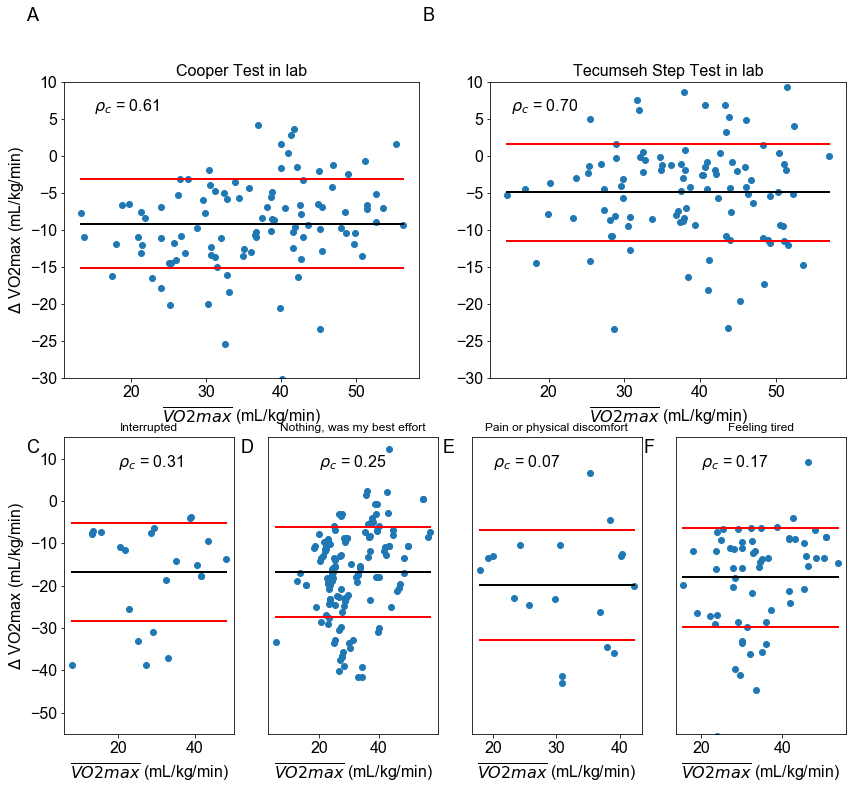

In [12]:
plt.figure(figsize=(14,12));

#Compare  tecumseh from polar, fitbit and camera to ground truth
tmp = tecumseh.query('metric=="polar"  and inClinic==True')[['externalId', 'vo2Max.Milligan2']].merge(metadata, on='externalId').dropna(subset=['vo2Max.Milligan2'])
print('Rho_c between Polar chest strap Tecusmeh and ground truth %0.2f.' %ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']));
tmp = tecumseh.query('metric=="fitbit"  and inClinic==True')[['externalId', 'vo2Max.Milligan2']].merge(metadata, on='externalId').dropna(subset=['vo2Max.Milligan2'])
print('Rho_c between Fitbit HR Tecusmeh and ground truth %0.2f.' %ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']));
tmp = tecumseh.query('metric=="camerahr"  and inClinic==True')[['externalId', 'vo2Max.Milligan2']].merge(metadata, on='externalId').dropna(subset=['vo2Max.Milligan2'])
print('Rho_c between camera HR Tecusmeh and ground truth %0.2f' %ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']));

# Cooper in lab validation (distance on track)
plt.subplot(2,2,1);
plot_bland_altman(metadata['Cooper VO2'], metadata['VO2max (mL/kg/min)'], 
                  ylabel='$\Delta$ VO2max (mL/kg/min)', xlabel='$\overline{VO2max}$ (mL/kg/min)');
plt.text(15,6, '$\\rho_c$ = %0.2f'%ccc(metadata['VO2max (mL/kg/min)'], metadata['Cooper VO2']),
        fontsize=16, fontname='Arial');
plt.ylim(-30,10)
plt.title('Cooper Test in lab', fontsize=16, fontname='Arial');
plt.grid(False);
## Compare the traditional Cooper protocol in lab as ground truth to the smartphone based Cooper
tmp = metadata.copy()
tmp = (df_12mt.query('inClinic==True')[['healthCode', 'mobile Cooper']].
       merge(tmp, on='healthCode').
       dropna(subset=['mobile Cooper', 'Cooper VO2']))
print('Rho_c between traditional Cooper protocol in lab to smartphone Cooper %0.3f' %ccc(tmp['Cooper VO2'],tmp['mobile Cooper']));



tmp = df_12mt[['estimated_smoothed_distance', 'actual_distance']].dropna()
print('Rho_c between Track distance and distance from phone,',ccc(tmp['estimated_smoothed_distance'], tmp['actual_distance']));

# Tecumseh in lab validation
plt.subplot(2,2,2);
lab_tecumseh = milligan2(metadata['Step Test HR Beats'].values, metadata['Age'].values, metadata['Sex'].values)
plot_bland_altman(lab_tecumseh, metadata['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='$\overline{VO2max}$ (mL/kg/min)');
plt.text(15,6, '$\\rho_c$ = %0.2f'%ccc(metadata['VO2max (mL/kg/min)'], lab_tecumseh),
        fontsize=16, fontname='Arial');
plt.ylim(-30,10)
plt.title('Tecumseh Step Test in lab', fontsize=16, fontname='Arial');
plt.grid(False);
# Compare the traditional Tecumseh protocol in lab as ground truth to the smartphone based Tecumseh
tmp = metadata.copy()
tmp['lab_tecumseh_vo2Max'] = lab_tecumseh
tmp = (tecumseh.query('metric=="camerahr" and inClinic==True')[['externalId', 'vo2Max.Milligan2']].
       merge(tmp, on='externalId').
       dropna(subset=['vo2Max.Milligan2', 'lab_tecumseh_vo2Max']))
print('Rho_c between traditional Tecumseh protocol in lab to Camera HR Tecusmeh %0.3f' %ccc(tmp['lab_tecumseh_vo2Max'], tmp['vo2Max.Milligan2']));



#In Home Cooper as performed by levels of effort
df = df_12mt.copy()
#Merge in true VO2
df = df.merge(metadata[['healthCode', 'Age', 'Sex','Cooper VO2', 'VO2max (mL/kg/min)']], how='left', on='healthCode')
df = df[~df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
print(df.groupby(['answers.surveyAfter'])['recordId'].count())
for i, effort in enumerate(['Interrupted', 'Nothing, was my best effort', 'Pain or physical discomfort', 'Feeling tired']):
    plt.subplot(2,4,5+i)
    tmp = df[df['answers.surveyAfter']==effort]
    plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='$\overline{VO2max}$ (mL/kg/min)');
    plt.text(20,8, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
            fontsize=16,  fontname='Arial');
    plt.title(effort, fontsize=12, fontname='Arial')
    plt.ylim(-55,15);
    plt.grid(False);
    if i==0:
        plt.ylabel('$\Delta$ VO2max (mL/kg/min)',fontsize=10, fontname='Arial')
    else:
        plt.yticks([])

#Clean up and style plots
for ax in plt.figure(1).axes:
    ax.get_xaxis().get_label().set_fontsize(16.000000);
    ax.get_yaxis().get_label().set_fontsize(16.000000);
    ax.get_xaxis().get_label().set_fontname("Arial");
    ax.get_yaxis().get_label().set_fontname("Arial");
    ax.lines[0].set_linewidth(2.0);
    ax.lines[1].set_linewidth(2.0);
    ax.lines[2].set_linewidth(2.0);
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16);

plt.figure(1).text(0.087, 0.95, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.48, 0.95, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.087, 0.45, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.3, 0.45, 'D', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.5, 0.45, 'E', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.7, 0.45, 'F', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");

#TODO Report % reporting maximal effort.

plt.savefig('../supplemental_figure1.pdf');


#### Supplemental Figure 1
Comparison of in lab performance using standard protocol for a) Cooper 12 minute run test and b) Tecumseh Step Test.  For each plot we are showing the difference between the ground truth VO2Max measurement and measuresments obtained using the distance run around track (for a) and heart rate as measures using finger on pulse measurement (for b).  These distance was also measured using GPS and heart rate was measured using a chest strap and fitbit. The concordance betwen distance measured around the track and measured using the GPS in the phone was 0.96. A-F) shows the concordance of the Cooper test for different values of the self reported effort.

# Compute test re-test reliability for the 3MST
Using the Interclass correlation coefficient compute the test re-test reliability

In [13]:
tmp =  (tecumseh.  
        query("metric=='camerahr' and inClinic==False")[['externalId', 'vo2Max.Milligan2']].
        dropna(). 
        groupby('externalId').filter(lambda x : len(x)>1))  #Remove external Ids with only 1 measurement
print('Number of participants with at least 2 at home step tests: %i'  %len(set(tmp.externalId)))
print('Test re-test ICC for 3-MST %0.3f' %icc(groups = tmp['externalId'], values = tmp['vo2Max.Milligan2']))

#df_12mt.head().T
tmp =  (df_12mt.  
        query("inClinic==False")[['healthCode', 'mobile Cooper']].
        dropna(). 
        groupby('healthCode').filter(lambda x : len(x)>1))  #Remove healthCode/external Ids with only 1 measurement
print('Number of participants with at least 2 at home 12-MRTs: %i'  %len(set(tmp.healthCode)))
print('Test re-test ICC for 12-MRT: %0.3f' %icc(groups = tmp['healthCode'], values = tmp['mobile Cooper']))



Number of participants with at least 2 at home step tests: 40
Test re-test ICC for 3-MST 0.856
Number of participants with at least 2 at home 12-MRTs: 76
Test re-test ICC for 12-MRT: 0.625


# Figure 2
Figure 2 and supplemental figure 2 are going to be generated together as I need to assess the concordance for many  different values of the confidence cutoff I will first compute those in a variable `confidenceDistributions`

[WARNING] /Users/mtummala/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':



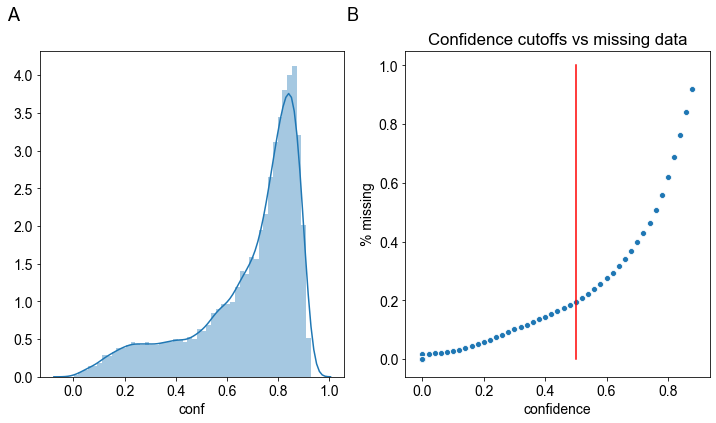

In [14]:
df = (calibration_df.
        query('method=="acf"').
        dropna(subset=['noninHR']))
nSteps=50
nWindows = len(df)
nWindows
confidenceDistributions = pd.DataFrame(np.zeros((nSteps, 3)), columns=['confidence', '% missing', 'concordance'])
        
for i, conf in enumerate(pd.np.arange(0,.9,1/nSteps)):
    # Resulting HR are filtered such that only those with confidence>0.5 are kept
    redIdx = (df.redConf>df.greenConf) | (df.greenConf.isna()) #Take care of missing values with second logical statement
    df = df.assign(hr = lambda x: np.where(redIdx, x.redHR, x.greenHR),
                   conf = lambda x: np.where(redIdx, x.redConf, x.greenConf),
                   activity = name)
    # If confidence <0.5 set hr to NaN
    df.loc[df.conf<conf,  'hr'] = np.nan
    confidenceDistributions.loc[i,:]=np.asarray([conf, 
                               (nWindows - sum(df.conf>conf))/nWindows,#/nWindows*100,
                               ccc(df.loc[df.conf>conf, 'hr'], df.loc[df.conf>conf, 'noninHR'])])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(df['conf'].dropna())


plt.subplot(1,2,2)
sns.scatterplot(x='confidence', y='% missing', data=confidenceDistributions);
plt.plot([.5,.5], [0,1], 'r');
plt.title('Confidence cutoffs vs missing data');    # Heart rate across channels is summarized as HR of red or green choosen by highest confidence
plt.figure(1).text(0.087, 0.95, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.48, 0.95, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");



**Supplemental Figure 2** Effect of different confidence cutoff on the amount of missing data from the calibration study. a) Distribution of best confidence across red and green channels in the calibrations study and b) percent of the 10 second windows that are filtered out at different cutoffs of the confidence score. The cutoff used in the analysis is 0.5 marked by the red line.

    confidence  % missing  concordance
25         0.5   0.195846     0.955376


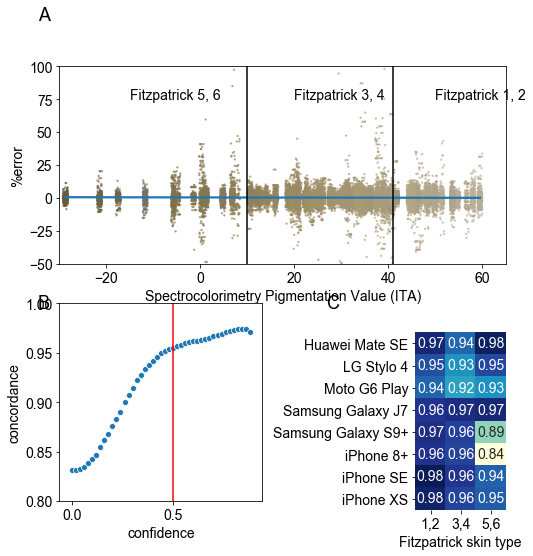

In [15]:
data = (calibration_df.
        query('method=="acf"').
        dropna(subset=['noninHR']).
        assign(fitzpatrick_group = lambda x: pd.cut(x['face.fitzpatrick'], 
                                                    [1,2,4,6], labels=['1,2', '3,4', '5,6'])))
redIdx = (data.redConf>data.greenConf) | (data.greenConf.isna()) #Take care of missing values with second logical statement
data = data.assign(hr = lambda x: np.where(redIdx, x.redHR, x.greenHR),
                   conf = lambda x: np.where(redIdx, x.redConf, x.greenConf),
                   activity = name)
# If confidence <0.5 set hr to NaN
data.loc[data.conf<CONF_CUTOFF,  'hr'] = np.nan
data = data.dropna(subset=['hr'])


plt.figure(figsize=(8, 8))
##Figure 2a % error vs skin color wihtout filtering
# Merge with colors for each ita
q = syn.tableQuery('SELECT participantID, R/255 as r, G/255 as g, B/255 as b FROM %s' %spectrocolorimetry_entity_id).asDataFrame()
data = data.merge(q, on='participantID',how='left')
q = data.dropna(subset=['face.fitzpatrick.ita', '%error'])
ax = plt.subplot(2,1,1);
sns.regplot(x='face.fitzpatrick.ita', y='%error',
           scatter_kws={"s": 2, 'alpha':.5, 'color':q[['r','g','b']].values},
           data=q, 
           x_jitter=.5, ax=ax);
plt.xlabel('Spectrocolorimetry Pigmentation Value (ITA)')
#plt.plot([55,55], [-50,100], 'k') #1
plt.plot([41,41], [-50,100], 'k') #2
plt.text(50, 75, 'Fitzpatrick 1, 2')
#plt.plot([28,28], [-50,100], 'k') #3
plt.plot([10,10], [-50,100], 'k') #4
plt.text(20, 75, 'Fitzpatrick 3, 4')
#plt.plot([-30,-30], [-50,100], 'k') #5
plt.text(-15, 75, 'Fitzpatrick 5, 6')

plt.ylim(-50,100);
plt.xlim(-30,65);
#plt.subplot(2,3,3)
#sns.distplot(data['%error'].dropna(), vertical=True)

##Figure 2b %confidence vs missing data
ax = plt.subplot(2,2,3)
sns.scatterplot(x='confidence', y='concordance', data=confidenceDistributions)
plt.ylim([.8,1])
plt.plot([.5,.5], [.8,1], 'r')
print(confidenceDistributions.query("confidence==@CONF_CUTOFF"))


##Figure 2c - heatmap
ax = plt.axes([0.743116, 0.110000, 0.156884, 0.308000])
c = data.groupby(['phone', 'fitzpatrick_group']).apply(lambda d: ccc(d['hr'],d['noninHR'])).unstack('fitzpatrick_group', 'phone')
sns.heatmap(c, annot=True,cbar=False, cmap="YlGnBu") #cbar_kws={'min':0, 'max':1});
plt.ylabel('')

plt.figure(1).text(0.087358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.087358, 0.459621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.587358, 0.459621, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");

plt.xlabel('Fitzpatrick skin type');
plt.savefig('../figure2.pdf');



**Figure 2**: Validation of heart rate measurements across different skin tones and hardware configurations.  A) Percent error in heart rate estimation from ground truth as determined by finger worn pulse-oximeter as a function of different colors captured by spectrocolorimetery under the jaw. Each dot represents a 10 second window of heart rate in one individual.  B) Distribution of concordance between heart rate using pulse oximetry and smartphone as the confidence cutoff is changed.  Red line represents the chosen cutoff used for analysis.  C) Concordance as a function of smartphone models and fitzpatrick skin tones.

Errors in heart rate estimate based on skin tone and device. A) percent error between pulse-ox and cell phone camera across different skin tones (from Fitzpatrick 5 and 6 to fitzpatrick 1 and 2).  Each dot represents a 10 second window of recording and is colored to represent skintone. The horizontal bars separate Fitzpatrick groups used for analysis.  B) Distribution

### Supplemental Figure for HR validation against Polar and fitbit

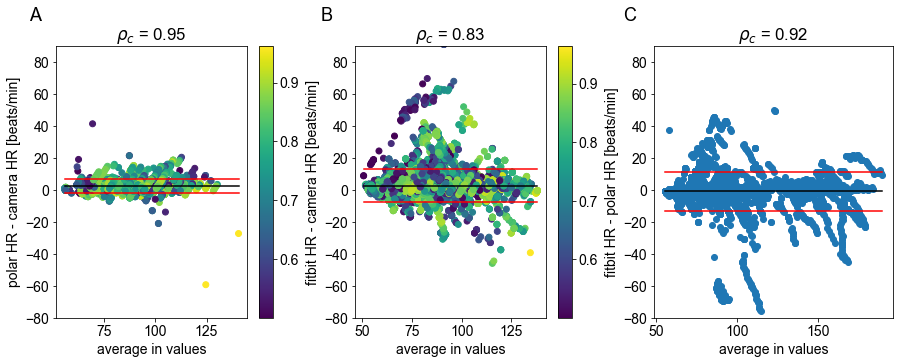

In [16]:
fig = plt.figure(figsize=(15,5));

df = df_hr.dropna(subset=['polar.hr', 'hr']).query("activity=='tecumseh'") #error=='none'
ax=plt.subplot(1,3,1);
plot_bland_altman(df['polar.hr'], df['hr'], c=df['conf'], ylabel='%s - %s [beats/min]'%('polar HR', 'camera HR'))
x=plt.title('$\\rho_c$ = %0.2f' %ccc(df['polar.hr'], df['hr']));
plt.colorbar()
plt.ylim(-80,90);

df = df_hr.dropna(subset=['fitbit.hr', 'hr']).query("activity=='tecumseh'")
ax=plt.subplot(1,3,2);
plot_bland_altman(df['fitbit.hr'], df['hr'], c=df['conf'], ylabel='%s - %s [beats/min]'%('fitbit HR', 'camera HR'))
x=plt.title('$\\rho_c$ = %0.2f' %ccc(df['fitbit.hr'], df['hr']));
plt.colorbar()
plt.ylim(-80,90);


df = df_hr.dropna(subset=['fitbit.hr', 'polar.hr'])
ax=plt.subplot(1,3,3);
plot_bland_altman(df['fitbit.hr'], df['polar.hr'], ylabel='%s - %s [beats/min]'%('fitbit HR', 'polar HR'))
x=plt.title('$\\rho_c$ = %0.2f' %ccc(df['fitbit.hr'], df['polar.hr']));
plt.ylim(-80,90);

plt.subplots_adjust(wspace=.25, hspace=.15);
plt.yticks();
fig.text(0.10, 0.95, 'A', transform=fig.transFigure, fontsize=18, fontname="Arial");
fig.text(0.37, 0.95, 'B', transform=fig.transFigure, fontsize=18, fontname="Arial");
fig.text(0.65, 0.95, 'C', transform=fig.transFigure, fontsize=18, fontname="Arial");

plt.savefig('../supplemental_figure3.pdf');


**Supplemental Figure 3** Bland Altman analysis comparing heart rate measurements in the *validation* dataset using data collected during the Tecumseh tests. In the validation cohort participants used multipe ways of collecting heart rate.  The method under test, using the smartphone camera was compared to: a) a Polar chest strap while in the clinic when both were used and b) a fitbit worn during the entirety of the study. For both a an b the comparison is colorcoded by the confidence score. c) We also compared  the polar strap to the fitbit for all time that both were worn.